# Matrix representation of quantum circuits -- notations and conventions
> A case study by building a tensor network to match qiskit conventions

- toc: true 
- badges: true
- comments: true
- categories: [qiskit, tensor networks, quantum concepts]
- image: images/grovercirc.png

# Intro
Normally I use `qiskit` to experiment with quantum circuits. As any higher level environment it is very convenient for common tasks, but may turn out too inflexible for unusual use cases. A somewhat opposite approach is to use much lower level tools to gain in flexibility at the expense of convenience. I wanted to use Google's [`tensornetwork`](https://tensornetwork.readthedocs.io/en/latest/) package for simulations and training of quantum circuits, but this requires building many things that are for free in `qiskit` from scratch. It is also necessary to become explicit about conventions for matrix representation of quantum circuits. As long as you stay within a single framework this may not be an issue. I always anticipated though, that a day will come when I need to face my fears and order all terms in a tensor product by hands. Now it seems I'm past the difficult part and I'm better writing this down in case I would need to do something similar in the future.

## Defining the problem
OK, so what is the problem? Consider the following simple circuit built in `qiskit`:

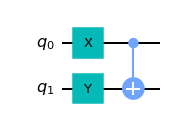

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

qc = QuantumCircuit(2)
qc.x(0)
qc.y(1)
qc.cx(0,1)
qc.draw(output='mpl')

It is not hard or ambiguous to interpret what this circuit does by inspecting the diagram. Say the input state is $q_0=|0\rangle$, $q_1=|1\rangle$. After $Y$ acts on $q_0$ it becomes $q_0\to X |0\rangle=|1\rangle$. Similarly, $q_1$ after $Y$ becomes $q_1\to Y|1\rangle=-i |0\rangle$. Since now $q_0$ is "on" the CNOT gate switches the state of $q_1$ further to $q_0 \to -i|1\rangle$. So the end result is that $q_0=|0\rangle, q_1=|1\rangle$ is transformed to $q_0=|1\rangle, q_1=-i|1\rangle$. Or perhaps a picture says it better

![](myimages/xycnot01.png)

Similarly we can work out what the circuit does for other computational basis states which by linearity fully fixes the action of the circuit. Although quite explicit, this is a clumsy description. This is why the matrix notation is usually used. And indeed, we can obtain the matrix corresponding to our quantum circuit quite easily in `qiskit`:

In [2]:
from qiskit.quantum_info import Operator, Statevector

U_qs = Operator(qc).data
U_qs

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j]])

It is important to realize that a number of conventions must be chosen before such explicit matrix representation can be written down. In the following I will clarify what are the conventions used in `qiskit` and reproduce the circuit with the `tensornetwork` library.

# States: vertical ordering

## Single qubit states
First we need to give matrix representations to two basis states of a single qubit. Here I think it is quite uncontroversial to chose
\begin{align}
|0\rangle = \begin{pmatrix}1\\0\end{pmatrix},\qquad |1\rangle = \begin{pmatrix}0\\1\end{pmatrix} \label{kets}
\end{align}

These are the "ket" vectors. Their "bra" counterparts are
\begin{align}
\langle 0| = \begin{pmatrix}1 & 0\end{pmatrix}, \qquad \langle 1| = \begin{pmatrix}0 & 1\end{pmatrix} \label{bras}
\end{align}

With these, the following operators can be computed
\begin{align}
|0\rangle\langle 0| = \begin{pmatrix}1 & 0 \\ 0 & 0\end{pmatrix},\qquad |0\rangle\langle 1| = \begin{pmatrix}0 & 1 \\ 0 & 0\end{pmatrix},\qquad |1\rangle\langle 0| = \begin{pmatrix}0 & 0 \\ 1 & 0\end{pmatrix},\qquad |1\rangle\langle 1| = \begin{pmatrix}0 & 0 \\ 0 & 1\end{pmatrix} \label{ketbras}
\end{align}
## Multiple qubit states
Where there is more than one qubit things become a bit more interesting and potentially confusing.The combined Hilbert space of two qubits $\mathcal{H}_2$ is a tensor product of single-qubit hilbert spaces $\mathcal{H}_2 = \mathcal{H}_1 \otimes \mathcal{H}_1$ but we need to decide which qubit goes first and which goes second. In `qiskit` a convention is adopted that additional qubits join from the *left*, i.e. when we have two qubits as here

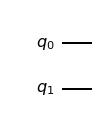

In [3]:
#collapse
qc01 = QuantumCircuit(2)
qc01.draw(output='mpl')


The state of the system is $|q_1\rangle\otimes |q_0\rangle$ (this is of course only true literally for [non-entangled states](https://idnm.github.io/blog/quantum%20concepts/qiskit/2021/07/12/Entanglement.html) ). OK, but how do we translate this into the matrix representation? The states in the tensor product of vector spaces can be represented by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) which is not symmetric with respect to permutation arguments. Best way to explain how Kronecker product works is, as usual, through examples:

\begin{align}
\begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} a \\ b \\ 0 \\ 0 \end{pmatrix},\qquad \begin{pmatrix} 0 \\ 1 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} 0\\ 0\\ a \\ b \end{pmatrix}
\end{align}
Result for generic left vector can be obtained by linearity
\begin{align}
\begin{pmatrix} x \\ y \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = x \begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} a \\ b\end{pmatrix} +y\begin{pmatrix} 0 \\ 1 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} x a\\ x b\\ y a \\ y b \end{pmatrix}  = \begin{pmatrix} x \begin{pmatrix} a\\ b\end{pmatrix} \\ y  \begin{pmatrix} a \\  b\end{pmatrix} \end{pmatrix}
\end{align}

The last notation here is a bit informal but it shows what happens. One just substitutes the right vector into all elements of the left vector, multiplied by the corresponding components of the left vector. The Kronecker product is defined in the same way for matrices of arbitrary size, not just for two vectors.

So, now we can compute matrix representations of states in the computation basis of two-qubit system

\begin{align}
|00\rangle = \begin{pmatrix}1\\0 \end{pmatrix} \otimes \begin{pmatrix}1\\0 \end{pmatrix} = \begin{pmatrix}1\\0\\0\\0\end{pmatrix},\quad |01\rangle = \begin{pmatrix}1\\0 \end{pmatrix} \otimes \begin{pmatrix}0\\1 \end{pmatrix} = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} \label{01}\\
|10\rangle = \begin{pmatrix}0\\1\end{pmatrix} \otimes \begin{pmatrix}1\\0 \end{pmatrix} = \begin{pmatrix}0\\0\\1\\0\end{pmatrix},\quad |11\rangle = \begin{pmatrix}0\\1\end{pmatrix} \otimes \begin{pmatrix}0\\1 \end{pmatrix} = \begin{pmatrix}0\\0\\0\\1\end{pmatrix}
\end{align}

There is a useful relation between the index of the non-zero element $n$ in the four-dimensional representation and the computational basis bitstring $q_1q_0$, namely $n=2q_1+q_0$. I.e. the bitstring $q_1q_0$ is the binary representation of the index $n$. This extends to arbitrary number of qubits, for example (try to obtain this from the tensor products!)
\begin{align}
|101\rangle = \begin{pmatrix}0\\0\\0\\0\\0\\1\\0\\0 \end{pmatrix} \label{101}
\end{align}

Don't believe me? Let's check that! In `qiskit` there is a convenient function to construct a vector representation from a bit string which we will take advantage of. First start with a two-qubit example:

In [4]:
s01 = Statevector.from_label('01')
s01.data

array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

 Comparing to \eqref{01} we find agreement. Similarly, 

In [5]:
s101 = Statevector.from_label('101')
s101.data

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

Again, this is in agreement with \eqref{101}. Now with conventions for the ordering of tensor products set we can proceed to operators.

# Operators: horizontal ordering
One can say that convention for states representation and ordering of tensor products is a "vertical" convention. There is also a "horizontal" convention which might be potentially confusing. Consider the following circuit

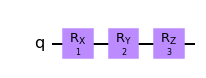

In [6]:
#collapse
qc123 = QuantumCircuit(1)
qc123.rx(1, 0)
qc123.ry(2, 0)
qc123.rz(3, 0)
qc123.draw(output='mpl')

Here, the operator $R_x$ is appplied first, the operator $R_y$ second and $R_z$ last. So in mathematical notation the circuit corresponds to $R_z R_y R_x$ and *not* to $R_x R_y R_z$. I think that the circuit notation is actually better. We think and write from left to right, this is also a direction that time flows on paper. When another thing happens, we write it to the right and it would be convenient to apply the corresponding operator to the right also. 

# Paper-and-pencil computation
With the set up in place we can compute the circuit of interest by hands. For convenience I plot it here once again:

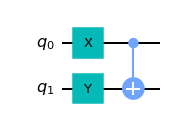

In [7]:
#collapse
qc.draw(output='mpl')

OK, so what is the unitary matrix corresponding to this circuit? It is 
\begin{align}
U = CNOT_{01} \cdot (Y\otimes X)
\end{align}
Here
\begin{multline}
CNOT_{01} = \mathbb{1}\otimes |0\rangle\langle 0|+X\otimes |1\rangle\langle 1|=\\\begin{pmatrix}1&0\\0&1\end{pmatrix}\otimes \begin{pmatrix}1&0\\0&0\end{pmatrix}+\begin{pmatrix}0&1\\1&0\end{pmatrix}\otimes \begin{pmatrix}0&0\\0&1\end{pmatrix}=\begin{pmatrix}1&0&0&0\\0&0&0&1\\0&0&1&0\\0&1&0&0\end{pmatrix}
\end{multline}
and
\begin{align}
Y\otimes X = \begin{pmatrix} 0& -i\\i&0\end{pmatrix} \otimes \begin{pmatrix} 0& 1\\1&0\end{pmatrix}=\begin{pmatrix}0&0&0&-i\\0&0&-i&0\\0&i&0&0\\i&0&0&0\end{pmatrix}
\end{align}
Multiplying them together gives
\begin{align}
U = \begin{pmatrix}0 & 0 & 0 & -i \\ i&0&0&0 \\ 0 & i & 0 & 0 \\ 0 & 0 & -i & 0\end{pmatrix}
\end{align}
Alright, so this is indeed the matrix that `qiskit` computes:

In [8]:
U_qs

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j]])

We can now also check that that the states evolve as we expected. For example recall that we computed that our quantum circuit maps $q_0 =|0\rangle, q_1 =|1\rangle$ to $q_0 =|1\rangle, q_1 =|1\rangle$ with an overall phase $-i$. Agreement with  `qiskit` can be checked as follows:

In [9]:
Statevector.from_label('10').evolve(qc).data == -1j*Statevector.from_label('11').data

array([ True,  True,  True,  True])

# Implementation with `tensornetworks`

I will not give a proper introduction to tensor networks but just mention a couple of facts relevant for the discussion.

First thing we will need are the matrices defining $X, Y$ and $CNOT$ gates. Let us introduce them.

In [10]:
import numpy as np

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
CNOT = np.array([[1, 0, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0]])

## An aside about reshaping
Note that as written, $CNOT$ is a $4\times4$ matrix. As a quantum gate it acts on two qubits, so it should rather be a four-legged tensor. This is the purpose of the reshaping operation. At first the reshaping might be a bit tricky, so let me illustrate it with an example. Introduce two $4\times4$ matrices and define their product:

In [12]:
A = np.random.rand(4,4)
B = np.random.rand(4,4)

AB = A @ B

Now define the corresponding four-legged tensors.

In [19]:
import tensornetwork as tn

a = tn.Node(A.reshape(2,2,2,2))
b = tn.Node(B.reshape(2,2,2,2))

By contracting the legs (or "edges" in terminology of `tensornetworks`) appropriately, we can reproduce the matrix multiplication. First the code:

In [14]:
a[2] ^ b[0]
a[3] ^ b[1]

ab = tn.contractors.greedy([a, b], output_edge_order=[a[0], a[1], b[2], b[3]]).tensor

We can check that the contraction performed in this way exactly reproduces the matrix multiplication of original $4\times4$ matrices:

In [15]:
np.allclose(AB, ab.reshape(4,4))

True

This can be interpreted graphically as follows. First, the reshaping procedure can be thought of splitting each four-dimensional leg of the original matrix into two two-dimensional ones

![](myimages/abtensors.jpg)

The labels on the legs have nothing to do with qubit states, these are just indices of edges as assigned by `tn.Node` operation on our matrices. The matrix multiplication of the original matrices in terms of four-legged tensors then can be draws as follows

![](myimages/abtensorproduct.jpg)

The index arrangements in the last part explain why we connected the edges in our code the way we did. This is something to watch out for. For example, connecting edges of two identity tensors in the wrong way may produce a $SWAP$ gate.

## Tensor product ordering
The matrix representation of a tensor diagram like this

![](myimages/kroneckertensor.jpg)

also comes with a convention for the ordering of tensor product. In `tensornetwork` as well as in my opinion it is natural to order top-down, i.e. the above diagram is $U\otimes \mathbb{1}$ instead of $\mathbb{1}\otimes U$ as is adopted in `qiskit`. 


## Circuit from tensor network
Alright, not we are in a position to reproduce the circuit unitary from the tensor network with nodes `x`, `y` and `cnot`:

In [46]:
x, y, cnot = list(map(tn.Node, [X, Y, CNOT.reshape(2,2,2,2)]))

cnot[2] ^ y[0]
cnot[3] ^ x[0]


U_tn = tn.contractors.greedy([cnot, x, y], output_edge_order=[cnot[0], cnot[1], y[1], x[1]]).tensor

This way of contracting the edges corresponds to the following diagram:

![](myimages/cnotxy.jpg)

Note that this is basically the original circuit with both the vertical and the horizontal directions reversed. The horizontal reversal is due to mathematical vs circuit notation (circuit is better!) and the vertical reversal is due to the mismatch between `qiskit` and `tensornetwork` ordering of tensor product (`tensornetwork`'s is better!). We can check that the unitary we obtain from this tensor network agrees with `qiskit`'s

In [48]:
np.allclose(U_tn.reshape(4,4), U_qs)

True

## A better way
I find all this misalignment very inconvenient and hard to debug. Ideally I want to look at the quantum circuit and construct the corresponding tensor network just as I read a text: from left to right and from top to bottom. Here I propose a solution which seems much more satisfactory to me. We will deal with horizontal reversal by first defining edges and then applying gates to them. This way we can read the circuit from left to right and simply add new gates, just as in `qiskit`. I will not try to revert the vertical direction directly, because I find it hard to think upside down. Instead, for comparison with `qiskit` I will use a built-in `reverse_bits` method.

So let start by defining a function that applies a given gate on the circuit (this is a slight modification of an [example](https://tensornetwork.readthedocs.io/en/latest/quantum_circuit.html) from `tensornetwork` docs) :

In [153]:
def apply_gate(qubits, gate_tensor, positions):
    
    gate = tn.Node(gate_tensor)
    assert len(gate.edges) == 2*len(positions), 'Gate size does not match positions provided.'
    

    for i, p in enumerate(positions):
        # Connect RIGHT legs of the gate to the active qubits
        gate[i+len(positions)] ^ qubits[p] 
        # Reassing active qubits to the corresponding LEFT legs of the gate 
        qubits[p] = gate[i]

Importantly, here, in contrast to the official docs, we append the gate from the *left*, so that a sequence of application of some $G_1$ followed by $G_2$ is equivalent to the application of $G_2\cdot G_1$. Now there is one more subtlety. Previously we used matrix representation of $CNOT$ assuming that the lower uppermost qubits comes last in the tensor product. Now that we decided to turn this convention upside down our matrix representation of $CNOT$ must be $CNOT =|0\rangle\langle 0|\otimes \mathbb{1}+|1\rangle\langle 1|\otimes X$ or explicitly

In [ ]:
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]]).reshape(2,2,2,2)

With that we are ready to reconstruct our original circuit in a convenient way:

In [158]:
# The context manager  `NodeCollection` is a bit of a magic trick
# which keeps track of all tensors in the network automatically.

all_nodes = []
with tn.NodeCollection(all_nodes): 
    id0 = tn.Node(np.identity(4).reshape(2,2,2,2))
    qubits0 = id0.edges[2:4]
    qubits = id0.edges[0:2]

    apply_gate(X, qubits, [0])
    apply_gate(Y, qubits, [1])
    apply_gate(CNOT, qubits, [0,1])
    
U_tn = tn.contractors.greedy(all_nodes, output_edge_order=qubits+qubits0).tensor.reshape(4,4)

Now let us check!

In [159]:
U_reversed_qs = Operator(qc.reverse_bits()).data
np.allclose(U_tn, U_reversed_qs)

True

Wohoo! If that looked simple to you I'm happy. It took me several hours of debugging to finally match the two matrices. Just to make sure, let me conclude with a more complicated example.

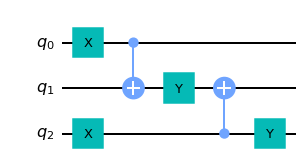

In [163]:
qc3 = QuantumCircuit(3)
qc3.x(0)
qc3.cx(0, 1)
qc3.y(1)
qc3.x(2)
qc3.cx(2, 1)
qc3.y(2)

qc3.draw(output='mpl')

As you can see, constructing the tensor network analog works more or less identically:

In [161]:
all_nodes = []
with tn.NodeCollection(all_nodes):
    id0 = tn.Node(np.identity(8).reshape(2,2,2,2,2,2))
    qubits0 = id0.edges[3:6]
    qubits = id0.edges[0:3]

    apply_gate(X, qubits, [0])
    apply_gate(CNOT, qubits, [0, 1])
    apply_gate(Y, qubits, [1])
    apply_gate(X, qubits, [2])
    apply_gate(CNOT, qubits, [2, 1])
    apply_gate(Y, qubits, [2])

And now we compare:

In [162]:
Utest_tn = tn.contractors.greedy(all_nodes, output_edge_order=qubits+qubits0).tensor.reshape(8,8)
Utest_qs = Operator(qctest.reverse_bits()).data

np.allclose(Utest_tn, Utest_qs)

True

Alright, this resounding **True** is the best way to conclude I can think of :) Any questions are welcome in the comments.